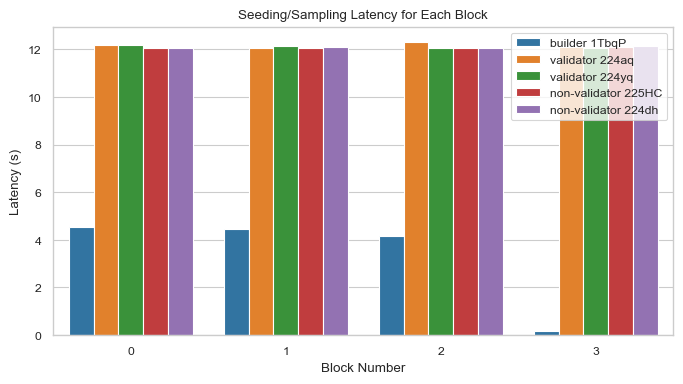

In [51]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def merge_nonbuilder_latencies(latency_files, nonbuilder_type):
    """
    Merge all validator latency files into one dataframe
    """
    validator_latency_dfs = []
    for validator_latency_file in latency_files:
        validator_latency_df = pd.read_csv(validator_latency_file)
        validator_latency_df['filename'] = validator_latency_file.replace("_latency_stats_validator.csv", "")
        validator_latency_df["node_type"] = nonbuilder_type
        validator_latency_df['block_id'] = range(len(validator_latency_df))
        validator_latency_df = validator_latency_df[ ["node_type", "filename", "block_id", "Total Sampling Latency (us)"] ]
        
        validator_latency_dfs.append(validator_latency_df)

    return pd.concat(validator_latency_dfs)

# Get builder file
builder_files = [file for file in os.listdir() if file.endswith('builder.csv')]
builder_latency_file = [file for file in builder_files if "latency_stats" in file][0]

# Get validator files
validator_files = [file for file in os.listdir() if file.endswith('_validator.csv')]
validator_latency_files = [file for file in validator_files if "latency_stats" in file]

# Get non validator files
non_validator_files = [file for file in os.listdir() if file.endswith('_nonvalidator.csv')]
non_validator_latency_files = [file for file in non_validator_files if "latency_stats" in file]

# Get validator latency stats
validator_latency_df = merge_nonbuilder_latencies(validator_latency_files, "validator")
validator_latency_df['Latency (s)'] = validator_latency_df['Total Sampling Latency (us)'] / 1_000_000
validator_latency_df = validator_latency_df[ ["node_type", "filename", "block_id", "Latency (s)"] ]

# Get non validator latency stats
non_validator_latency_df = merge_nonbuilder_latencies(non_validator_latency_files, "non-validator")
non_validator_latency_df['Latency (s)'] = non_validator_latency_df['Total Sampling Latency (us)'] / 1_000_000
non_validator_latency_df = non_validator_latency_df[ ["node_type", "filename", "block_id", "Latency (s)"] ]

# Get builder latency stats
builder_latency_df = pd.read_csv(builder_latency_file)
seeding_latencies_us = builder_latency_df["Seeding Latency (us)"]
seeding_latencies = seeding_latencies_us / 1_000_000

# Merge builder and validator latency stats
builder_latency_df['filename'] = builder_latency_file.replace("_latency_stats_builder.csv", "")
builder_latency_df['block_id'] = range(len(builder_latency_df))
builder_latency_df["node_type"] = "builder"
builder_latency_df = builder_latency_df[ ["node_type", "filename", "block_id", "Seeding Latency (us)"] ]
builder_latency_df = builder_latency_df.rename(columns={"Seeding Latency (us)": "Latency (s)"})
builder_latency_df['Latency (s)'] = seeding_latencies

latency_df = pd.concat([builder_latency_df, validator_latency_df, non_validator_latency_df])
latency_df['node_label'] = latency_df['node_type'] + " " + latency_df['filename'].apply(lambda x: x[:5])

# Plot multi bar chart of latency for each block
sns.set_style("whitegrid")
sns.set_context("paper")
plt.figure(figsize=(8, 4))
plt.title("Seeding/Sampling Latency for Each Block")
sns.barplot(x="block_id", y="Latency (s)", hue="node_label", data=latency_df)
plt.xlabel("Block Number")
plt.ylabel("Latency (s)")
plt.legend()
plt.show()
plt.close()